In [1]:
%matplotlib inline

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import numpy as np, cmath,scipy as sp
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log,log10, random, convolve#import basic functions from numpy that we'll need
from numpy.fft import fft, ifft
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

eeg = scipy.io.loadmat('sub13_eeg_sleepstage_data.mat')

import pandas as pd
eegdata=pd.DataFrame()
eegdata['ch1'] = np.squeeze(eeg["eeg_data"][:,1:2])
eegdata['ch2'] = np.squeeze(eeg["eeg_data"][:,2:3])
eegdata['ch3'] = np.squeeze(eeg["eeg_data"][:,3:4])
eegdata['ch4'] = np.squeeze(eeg["eeg_data"][:,4:5])
eegdata['ch5'] = np.squeeze(eeg["eeg_data"][:,5:6])
eegdata['ch6'] = np.squeeze(eeg["eeg_data"][:,6:7])
eegdata['stage'] = np.squeeze(eeg["eeg_data"][:,7:8])

X = eegdata.ix[:,0:6].values
y = eegdata.ix[:,6].values

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [2]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
    
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['CH %s' %i for i in range(1,7)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['CH %s' %i for i in range(1,7)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Variance in percent'),
        title='Variance by different principal components')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

Eigenvectors 
[[ 0.42483442  0.37485884  0.41156153 -0.16990413  0.68224003 -0.12367213]
 [ 0.43049776  0.35942972  0.3858865  -0.11003732 -0.68118056  0.2458829 ]
 [ 0.43671974  0.14793151 -0.47042238  0.06449574 -0.18506546 -0.72641999]
 [ 0.42555915  0.11396527 -0.54449398  0.31567678  0.1902629   0.61121668]
 [ 0.36911244 -0.5916802  -0.11337832 -0.69896298  0.00958065  0.11033983]
 [ 0.35513193 -0.58765113  0.38869416  0.60552754 -0.00077455 -0.10392355]]

Eigenvalues 
[ 4.12497529  0.86572816  0.56091732  0.25822837  0.06327359  0.12687809]
Eigenvalues in descending order:
4.12497528993
0.865728160835
0.56091732344
0.258228374368
0.126878092879
0.0632735914359


In [3]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

traces = []

for name in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):

    trace = Scatter(
        x=Y_sklearn[y==name,0],
        y=Y_sklearn[y==name,1],
        mode='markers',
        name=name,
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning:

using a boolean instead of an integer will result in an error in the future

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning:

using a boolean instead of an integer will result in an error in the future



In [3]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(6,1),
                     (eig_pairs[1][1].reshape(6,1))))

print('Matrix W:\n', matrix_w)

Y = X_std.dot(matrix_w)
Y

Matrix W:
 [[ 0.42483442  0.37485884]
 [ 0.43049776  0.35942972]
 [ 0.43671974  0.14793151]
 [ 0.42555915  0.11396527]
 [ 0.36911244 -0.5916802 ]
 [ 0.35513193 -0.58765113]]


array([[ 0.84349305, -2.75392339],
       [ 0.84349305, -2.75392339],
       [ 2.79072735, -2.92856237],
       ..., 
       [ 0.11231292, -0.01509847],
       [ 0.11231292, -0.01509847],
       [ 0.07478933, -0.04997599]])

In [4]:
traces = []
len(Y)
for stage in (1, 0, -1,-2,-3,-4,-5):

    trace = Scatter(
        x=Y[y==stage,0][:500],
        y=Y[y==stage,1][:500],
        mode='markers',
        name=stage,
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(showlegend=True,
                scene=Scene(xaxis=XAxis(title='PC1'),
                yaxis=YAxis(title='PC2'),))

fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [5]:
custom_eeg_data = pd.DataFrame()
custom_eeg_data['pca']=np.squeeze(Y[:,1])
custom_eeg_data['stage']=np.round(np.squeeze(eeg["eeg_data"][:,7:8]))
custom_eeg_data
custom_eeg_data['stage'].value_counts()

-2.0    2375229
-1.0    2157673
 1.0    1976131
-5.0     303523
-3.0     255806
 0.0     133029
-4.0       2448
Name: stage, dtype: int64

In [34]:
custom_eeg_data =custom_eeg_data.loc[(custom_eeg_data['stage']==0) | (custom_eeg_data['stage']==1) | (custom_eeg_data['stage']==-1) | 
                                     (custom_eeg_data['stage']==-2) | (custom_eeg_data['stage']==-3) | (custom_eeg_data['stage']==-4) |
                                     (custom_eeg_data['stage']==-5)]
custom_eeg_data
df1 = custom_eeg_data.loc[custom_eeg_data['stage']==1]
df1 = df1[:20000]
df0 = custom_eeg_data.loc[custom_eeg_data['stage']==0]
df0 = df0[:20000]
dfm1 = custom_eeg_data.loc[custom_eeg_data['stage']==-1]
dfm1 = dfm1[:20000]
dfm2 = custom_eeg_data.loc[custom_eeg_data['stage']==-2]
dfm2 = dfm2[:20000]
dfm3 = custom_eeg_data.loc[custom_eeg_data['stage']==-3]
dfm3 = dfm3[:20000]
dfm4 = custom_eeg_data.loc[custom_eeg_data['stage']==-4]
dfm4 = dfm4[:20000]
dfm5 = custom_eeg_data.loc[custom_eeg_data['stage']==-5]
dfm5 = dfm5[:20000]
main=df1.append(df0).append(dfm1).append(dfm2).append(dfm3).append(dfm4).append(dfm5)
main = main.astype(float).fillna(main.mean())
main['stage'].value_counts()


final=pd.DataFrame()
final['pca']=main['pca']
final['stage']=main['stage']

In [44]:
custom_eeg_data =custom_eeg_data.loc[(custom_eeg_data['stage']==0) | (custom_eeg_data['stage']==1) | (custom_eeg_data['stage']==-1) | 
                                     (custom_eeg_data['stage']==-2) | (custom_eeg_data['stage']==-3) | (custom_eeg_data['stage']==-4) |
                                     (custom_eeg_data['stage']==-5)]
custom_eeg_data
df1 = custom_eeg_data.loc[custom_eeg_data['stage']==1]
df1 = df1[:20000]
df0 = custom_eeg_data.loc[custom_eeg_data['stage']==0]
df0 = df0[:20000]
dfm1 = custom_eeg_data.loc[custom_eeg_data['stage']==-1]
dfm1 = dfm1[:20000]
dfm2 = custom_eeg_data.loc[custom_eeg_data['stage']==-2]
dfm2 = dfm2[:20000]
dfm3 = custom_eeg_data.loc[custom_eeg_data['stage']==-3]
dfm3 = dfm3[:20000]
dfm5 = custom_eeg_data.loc[custom_eeg_data['stage']==-5]
dfm5 = dfm5[:20000]
main=df1.append(df0)
main = main.astype(float).fillna(main.mean())
main['stage'].value_counts()


final=pd.DataFrame()
final['pca']=main['pca']
final['stage']=main['stage']
main['stage'].value_counts()

0.0    20000
1.0    20000
Name: stage, dtype: int64

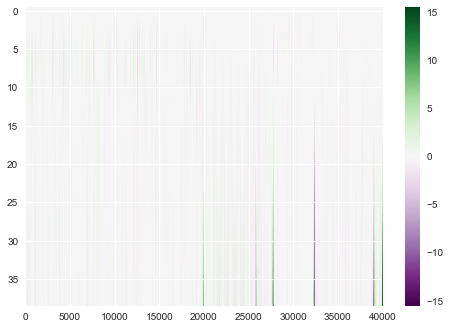

In [45]:
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = main['pca']
widths1 = np.arange(1,40)
cwtmatr1 = signal.cwt(sig, signal.ricker, widths1)
im=plt.imshow(cwtmatr1, cmap='PRGn', aspect='auto',vmax=abs(cwtmatr1).max(), vmin=-abs(cwtmatr1).max())
plt.colorbar(im)
plt.show()

In [46]:
def plot_fun(sig):
    plt.plot(sig)
    plt.show()

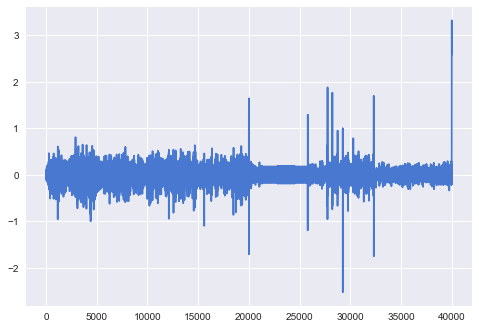

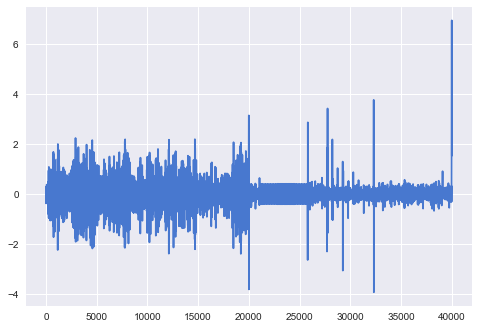

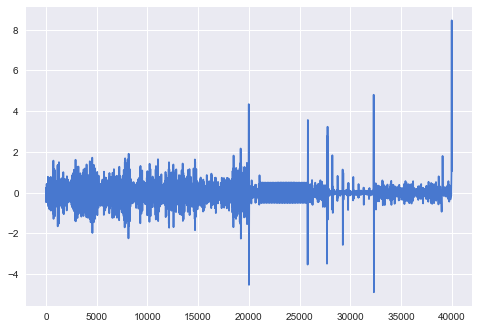

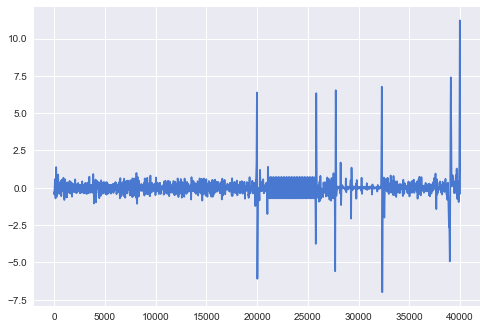

In [47]:
delta=np.mean(cwtmatr1[0:4],axis=0)
theta=np.mean(cwtmatr1[5:8],axis=0)
alpha=np.mean(cwtmatr1[8:12],axis=0)
beta=np.mean(cwtmatr1[12:35],axis=0)
plot_fun(delta)
plot_fun(theta)
plot_fun(alpha)
plot_fun(beta)

In [48]:
import pandas as pd
data=pd.DataFrame()
delta=np.mean(cwtmatr1[0:4],axis=0)
theta=np.mean(cwtmatr1[5:8],axis=0)
alpha=np.mean(cwtmatr1[8:12],axis=0)
beta=np.mean(cwtmatr1[12:35],axis=0)
main['alpha']=alpha
main['beta']=beta
main['delta']=delta
main['theta']=theta
main.head()

,pca,stage,alpha,beta,delta,theta
122752,-0.083165,1.0,-0.061114,-0.288412,0.029730,0.054253
122753,-0.083165,1.0,-0.113436,-0.311923,-0.010910,0.009674
122754,-0.092115,1.0,-0.166980,-0.334301,-0.026620,-0.038508
122755,-0.092115,1.0,-0.220323,-0.355295,-0.035942,-0.088563
122756,-0.155666,1.0,-0.271949,-0.374668,-0.055139,-0.138784


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(main.iloc[:,2:6], main.iloc[:,1], test_size=.4, random_state=42)

In [50]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.72531250000000003

In [51]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(3)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.82643750000000005

In [52]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.77587499999999998

In [54]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.77275000000000005

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    #AdaBoostClassifier(),
    #GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name,clf in zip(names,classifiers):
    clf.fit(main.iloc[:,2:6], main.iloc[:,1])
    out_=clf.predict(main.iloc[:,2:6])
    print(name)
    print(accuracy_score(main.iloc[:,1], out_))

Nearest Neighbors
0.638983333333
Linear SVM
0.187716666667
RBF SVM
0.379108333333


MemoryError: 

In [122]:
main.to_csv('extracted_file.csv', index=False, encoding='utf-8')

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



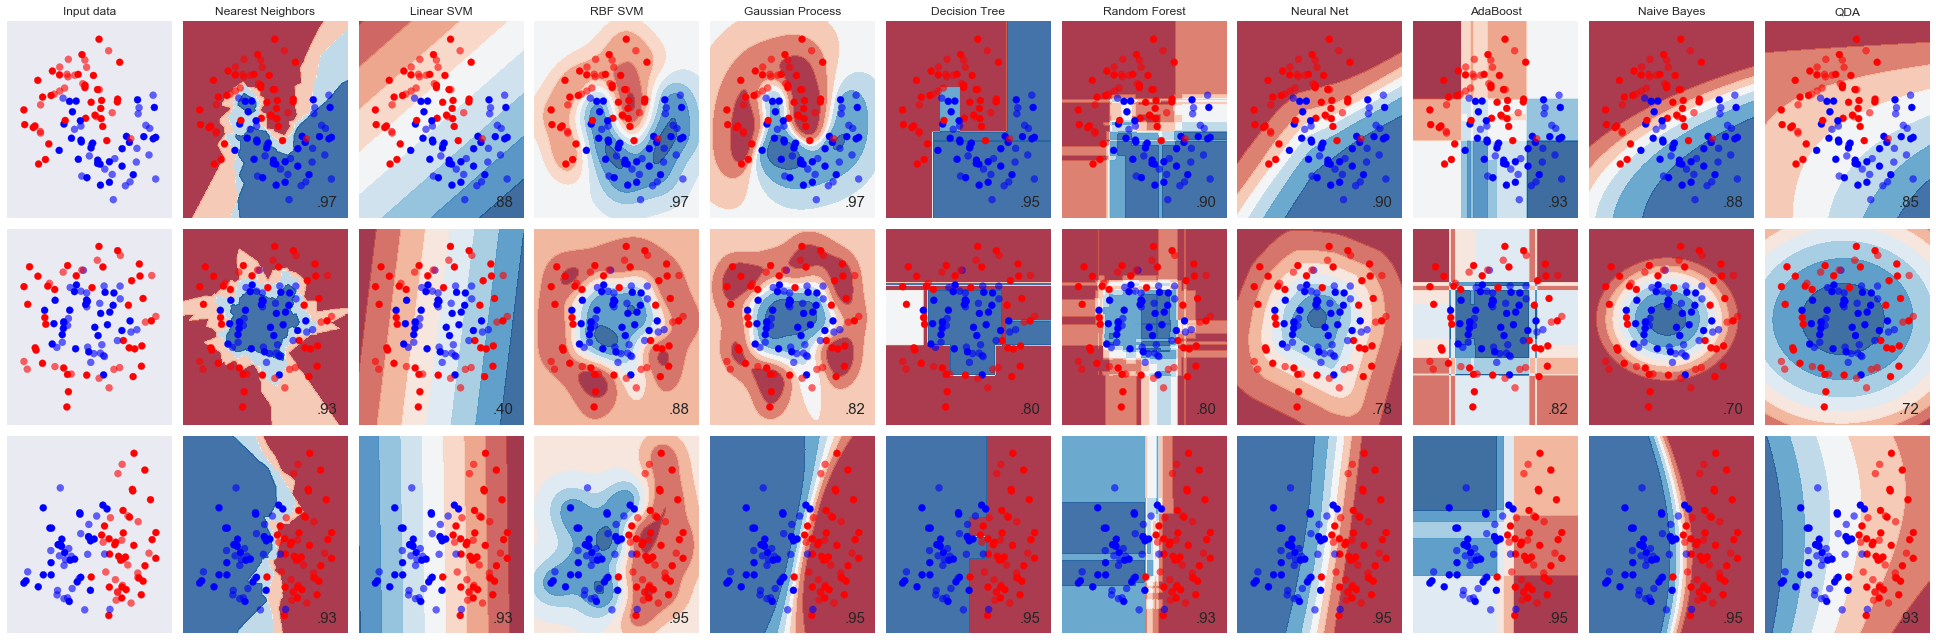

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

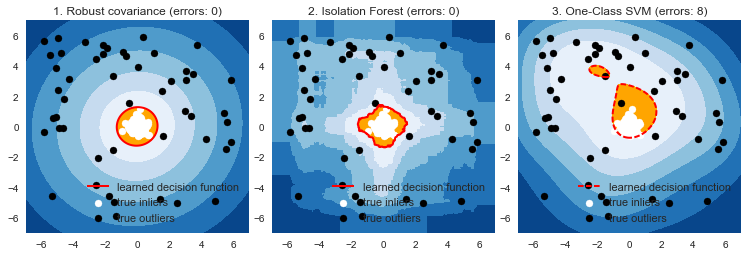

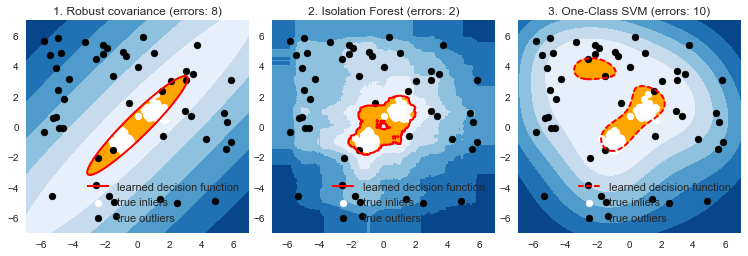

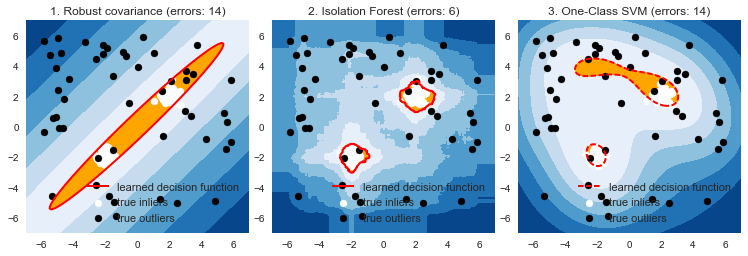

In [34]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(10.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11),
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()

In [46]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 500
random_x = np.linspace(0, 1, len(delta))
random_y = np.random.randn(len(delta))

# Create a trace
trace = go.Scatter(
    x = main.iloc[:,3].as_matrix()
)

data = [trace]

py.iplot(data, filename='basic-line')

C:\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:218: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



The draw time for this plot will be slow for all clients.


C:\Anaconda3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [45]:
main.iloc[:,3].as_matrix()

array([ 0.25531676,  0.22725179,  0.1976316 , ..., -0.05413237,
       -0.06768621, -0.08092968])

In [42]:
np.random.randn(N)

array([-0.41980804,  0.87607221, -0.82421959, -0.70250361,  0.55945189,
       -0.30005273,  1.20347188,  0.87485652, -0.6926873 , -1.27933874,
       -0.48244933, -0.73442132,  0.47905052,  0.59870651,  0.19925213,
       -1.52924352,  0.90763624,  1.4349338 ,  0.11782677, -0.54137363,
        0.51099754, -0.64637233,  0.95637865,  0.91396202,  0.07379777,
       -0.31003852,  1.24471007,  1.14259446, -1.21038576,  0.24914944,
        1.44945596,  1.85008467, -0.93845165,  0.52135684, -1.55586116,
        0.58343931, -0.63207176, -0.38515327, -0.98761763,  1.00089061,
       -1.38721926, -0.04775532,  0.69697876,  0.9173489 ,  0.68949905,
        1.92255378, -0.1702742 , -1.18117314,  0.33718653, -0.23126282,
        0.78919249,  0.61805212, -2.4068559 , -0.80381394,  1.94789854,
       -0.47531505, -0.42686655, -1.73373365, -1.07972803,  2.13373105,
        0.3680757 , -0.03834912,  1.0735576 , -1.67176934, -0.34920314,
       -1.00889965, -0.03396604,  1.98569006,  1.25281972,  0.62

In [64]:
from sklearn import preprocessing
binarizer = preprocessing.Binarizer(threshold=1.1)
X_std =binarizer.transform(X)

In [65]:
len(X_std)

7409919

In [101]:
round(eegdata['stage']).value_counts()

-2.0    2375229
-1.0    2157673
 1.0    1976131
-5.0     303523
-3.0     255806
 0.0     133029
-4.0       2448
Name: stage, dtype: int64